In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [2]:
dev = qml.device("default.qubit", wires=3)

In [3]:
def get_angles(x):

    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(
        np.sqrt(x[2] ** 2 + x[3] ** 2)
        / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2)
    )

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])

In [4]:
def statepreparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

In [5]:
x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0], requires_grad=False)
ang = get_angles(x)


@qml.qnode(dev)
def test(angles):

    statepreparation(angles)

    return qml.expval(qml.PauliZ(0))


test(ang)

print("x               : ", x)
print("angles          : ", ang)
print("amplitude vector: ", np.real(dev.state))

x               :  [0.53896774 0.79503606 0.27826503 0.        ]
angles          :  [ 0.56397465 -0.          0.         -0.97504604  0.97504604]
amplitude vector:  [ 5.38967743e-01  0.00000000e+00  7.95036065e-01  0.00000000e+00
  2.78265032e-01  0.00000000e+00 -2.77555756e-17  0.00000000e+00]


In [6]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [7]:
def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

In [8]:
@qml.qnode(dev)
def circuit(weights, angles):
    statepreparation(angles)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))


def variational_classifier(weights, bias, angles):
    return circuit(weights, angles) + bias


# def cost(weights, bias, features, labels, l_features=None, l_labels=None, lookahead=False):
#     if lookahead:
#         predictions = [variational_classifier(weights, bias, f) for f in l_features]
#         return square_loss(l_labels, predictions)
#     else:
#         predictions = [variational_classifier(weights, bias, f) for f in features]
#         return square_loss(labels, predictions)
    
def cost(weights, bias, features, labels, sample_batch_size=5, feats_train=None, Y_train=None, lookahead=False):
    if lookahead:
        num_train = int(0.75 * len(Y_train))
        batch_index_lookaround = np.random.randint(0, num_train, (sample_batch_size,))
        feats_train_lookaround_batch = feats_train[batch_index_lookaround]
        Y_train_lookaround_batch = Y_train[batch_index_lookaround]
        predictions = [variational_classifier(weights, bias, f) for f in feats_train_lookaround_batch]
        return square_loss(Y_train_lookaround_batch, predictions)
    else:
        predictions = [variational_classifier(weights, bias, f) for f in features]
        return square_loss(labels, predictions)

In [9]:
data = np.loadtxt("./data/iris_classes1and2_scaled.txt")
X = data[:, 0:2]
print("First X sample (original)  :", X[0])

# pad the vectors to size 2^2 with constant values
padding = 0.3 * np.ones((len(X), 1))
X_pad = np.c_[np.c_[X, padding], np.zeros((len(X), 1))]
print("First X sample (padded)    :", X_pad[0])

# normalize each input
normalization = np.sqrt(np.sum(X_pad ** 2, -1))
X_norm = (X_pad.T / normalization).T
print("First X sample (normalized):", X_norm[0])

# angles for state preparation are new features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print("First features sample      :", features[0])

Y = data[:, -1]

First X sample (original)  : [0.4  0.75]
First X sample (padded)    : [0.4  0.75 0.3  0.  ]
First X sample (normalized): [0.44376016 0.83205029 0.33282012 0.        ]
First features sample      : [ 0.67858523 -0.          0.         -1.080839    1.080839  ]


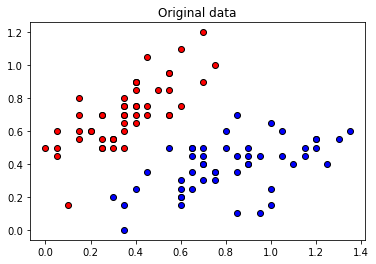

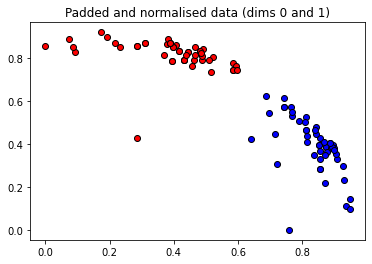

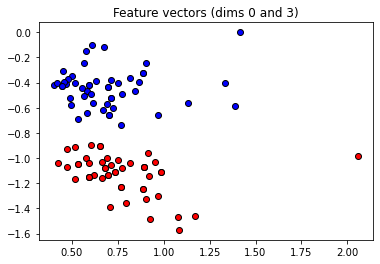

In [10]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", edgecolors="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", edgecolors="k")
plt.title("Original data")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(
    X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="b", marker="o", edgecolors="k"
)
plt.scatter(
    X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="r", marker="o", edgecolors="k"
)
plt.title("Padded and normalised data (dims {} and {})".format(dim1, dim2))
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(
    features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", edgecolors="k"
)
plt.scatter(
    features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", edgecolors="k"
)
plt.title("Feature vectors (dims {} and {})".format(dim1, dim2))
plt.show()

In [11]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

In [12]:
num_qubits = 2
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

In [13]:
from pennylane.optimize import NesterovMomentumOptimizer
opt = NesterovMomentumOptimizer(0.01)
batch_size = 5
cost_nes = []
train_acc_nes = []
val_acc_nes = []

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(50):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)
    
    c = cost(weights, bias, features, Y)
    cost_nes.append(c)
    train_acc_nes.append(acc_train)
    val_acc_nes.append(acc_val)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, c, acc_train, acc_val)
    )

Iter:     1 | Cost: 1.4490948 | Acc train: 0.4933333 | Acc validation: 0.5600000 
Iter:     2 | Cost: 1.3309953 | Acc train: 0.4933333 | Acc validation: 0.5600000 
Iter:     3 | Cost: 1.1582178 | Acc train: 0.4533333 | Acc validation: 0.5600000 
Iter:     4 | Cost: 0.9795035 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     5 | Cost: 0.8857893 | Acc train: 0.6400000 | Acc validation: 0.7600000 
Iter:     6 | Cost: 0.8587935 | Acc train: 0.7066667 | Acc validation: 0.7600000 
Iter:     7 | Cost: 0.8496204 | Acc train: 0.7200000 | Acc validation: 0.6800000 
Iter:     8 | Cost: 0.8200972 | Acc train: 0.7333333 | Acc validation: 0.6800000 
Iter:     9 | Cost: 0.8027511 | Acc train: 0.7466667 | Acc validation: 0.6800000 
Iter:    10 | Cost: 0.7695152 | Acc train: 0.8000000 | Acc validation: 0.7600000 
Iter:    11 | Cost: 0.7437432 | Acc train: 0.8133333 | Acc validation: 0.9600000 
Iter:    12 | Cost: 0.7569196 | Acc train: 0.6800000 | Acc validation: 0.7600000 
Iter:    13 | Co

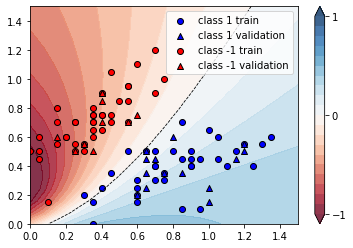

In [14]:
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 20), np.linspace(0.0, 1.5, 20))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.3 * np.ones((len(X_grid), 1))
X_grid = np.c_[np.c_[X_grid, padding], np.zeros((len(X_grid), 1))]  # pad each input
normalization = np.sqrt(np.sum(X_grid ** 2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array(
    [get_angles(x) for x in X_grid]
)  # angles for state preparation are new features
predictions_grid = [variational_classifier(weights, bias, f) for f in features_grid]
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
cnt = plt.contourf(
    xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both"
)
plt.contour(
    xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,)
)
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
plt.scatter(
    X_train[:, 0][Y_train == 1],
    X_train[:, 1][Y_train == 1],
    c="b",
    marker="o",
    edgecolors="k",
    label="class 1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == 1],
    X_val[:, 1][Y_val == 1],
    c="b",
    marker="^",
    edgecolors="k",
    label="class 1 validation",
)
plt.scatter(
    X_train[:, 0][Y_train == -1],
    X_train[:, 1][Y_train == -1],
    c="r",
    marker="o",
    edgecolors="k",
    label="class -1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == -1],
    X_val[:, 1][Y_val == -1],
    c="r",
    marker="^",
    edgecolors="k",
    label="class -1 validation",
)

plt.legend()
plt.savefig('nes_sgd.pdf')
plt.show()

In [16]:
opt = qml.GradientDescentOptimizer(0.01)
batch_size = 5
cost_sgd = []
train_acc_sgd = []
val_acc_sgd = []

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(50):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)
    
    c = cost(weights, bias, features, Y)
    cost_sgd.append(c)
    train_acc_sgd.append(acc_train)
    val_acc_sgd.append(acc_val)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, c, acc_train, acc_val)
    )

Iter:     1 | Cost: 1.4090295 | Acc train: 0.4933333 | Acc validation: 0.5600000 
Iter:     2 | Cost: 1.3785710 | Acc train: 0.4933333 | Acc validation: 0.5600000 
Iter:     3 | Cost: 1.3156363 | Acc train: 0.4933333 | Acc validation: 0.5600000 
Iter:     4 | Cost: 1.2383006 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     5 | Cost: 1.1654620 | Acc train: 0.4533333 | Acc validation: 0.5600000 
Iter:     6 | Cost: 1.1437112 | Acc train: 0.4533333 | Acc validation: 0.5600000 
Iter:     7 | Cost: 1.1357770 | Acc train: 0.4533333 | Acc validation: 0.5600000 
Iter:     8 | Cost: 1.1113134 | Acc train: 0.4533333 | Acc validation: 0.5600000 
Iter:     9 | Cost: 1.0910618 | Acc train: 0.4666667 | Acc validation: 0.5600000 
Iter:    10 | Cost: 1.0943880 | Acc train: 0.4666667 | Acc validation: 0.5600000 
Iter:    11 | Cost: 1.0659632 | Acc train: 0.4666667 | Acc validation: 0.5600000 
Iter:    12 | Cost: 1.0058811 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:    13 | Co

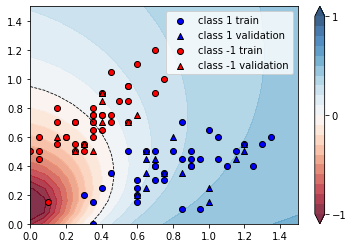

In [18]:
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 20), np.linspace(0.0, 1.5, 20))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.3 * np.ones((len(X_grid), 1))
X_grid = np.c_[np.c_[X_grid, padding], np.zeros((len(X_grid), 1))]  # pad each input
normalization = np.sqrt(np.sum(X_grid ** 2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array(
    [get_angles(x) for x in X_grid]
)  # angles for state preparation are new features
predictions_grid = [variational_classifier(weights, bias, f) for f in features_grid]
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
cnt = plt.contourf(
    xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both"
)
plt.contour(
    xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,)
)
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
plt.scatter(
    X_train[:, 0][Y_train == 1],
    X_train[:, 1][Y_train == 1],
    c="b",
    marker="o",
    edgecolors="k",
    label="class 1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == 1],
    X_val[:, 1][Y_val == 1],
    c="b",
    marker="^",
    edgecolors="k",
    label="class 1 validation",
)
plt.scatter(
    X_train[:, 0][Y_train == -1],
    X_train[:, 1][Y_train == -1],
    c="r",
    marker="o",
    edgecolors="k",
    label="class -1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == -1],
    X_val[:, 1][Y_val == -1],
    c="r",
    marker="^",
    edgecolors="k",
    label="class -1 validation",
)

plt.legend()
plt.savefig('sgd.pdf')
plt.show()

In [19]:
from pennylane.optimize.momentum import MomentumOptimizer
from laws_sgd import LAWS

sampling_method = "lookahead"
#sampling_method = "lookaheadrandomsmaple"
#sampling_method = "lookmultiahead"


gradient_method = "default"
#gradient_method = "adam-like"

opt = LAWS(delta= 0.5,
           lookaround_optimizer=MomentumOptimizer, 
           lookaround_stepsize= 0.01,
           lookaround_loop=5,
           sampling_method = sampling_method,
           gradient_method = gradient_method)

batch_size = 5

cost_wssgd = []
train_acc_wssgd = []
val_acc_wssgd = []

kwargs = {"sample_batch_size":5,
          "feats_train":feats_train,
          "Y_train":Y_train,
          "lookahead":False,}

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(50):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]

    weights, bias, _, _ = opt.step(cost, 
                                   weights, 
                                   bias, 
                                   feats_train_batch, 
                                   Y_train_batch,
                                   **kwargs)
    
    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)
    
    c = cost(weights, bias, features, Y)
    
    cost_wssgd.append(c)
    train_acc_wssgd.append(acc_train)
    val_acc_wssgd.append(acc_val)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, c, acc_train, acc_val)
    )

Iter:     1 | Cost: 1.2644784 | Acc train: 0.4933333 | Acc validation: 0.5600000 
Iter:     2 | Cost: 1.0511471 | Acc train: 0.5066667 | Acc validation: 0.5600000 
Iter:     3 | Cost: 0.8694414 | Acc train: 0.5600000 | Acc validation: 0.6400000 
Iter:     4 | Cost: 0.7273144 | Acc train: 0.8400000 | Acc validation: 1.0000000 
Iter:     5 | Cost: 0.7329533 | Acc train: 0.8000000 | Acc validation: 0.7200000 
Iter:     6 | Cost: 0.7025189 | Acc train: 0.7866667 | Acc validation: 0.8400000 
Iter:     7 | Cost: 0.7760966 | Acc train: 0.6400000 | Acc validation: 0.6400000 
Iter:     8 | Cost: 0.6840106 | Acc train: 0.7733333 | Acc validation: 0.7600000 
Iter:     9 | Cost: 0.6676009 | Acc train: 0.7733333 | Acc validation: 0.7600000 
Iter:    10 | Cost: 0.7622092 | Acc train: 0.6133333 | Acc validation: 0.6000000 
Iter:    11 | Cost: 0.6596869 | Acc train: 0.6666667 | Acc validation: 0.6400000 
Iter:    12 | Cost: 0.4990454 | Acc train: 0.9066667 | Acc validation: 0.9200000 
Iter:    13 | Co

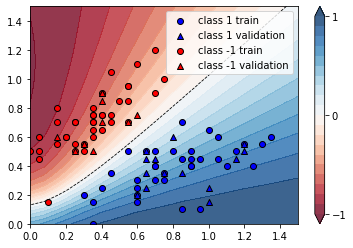

In [20]:
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 20), np.linspace(0.0, 1.5, 20))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.3 * np.ones((len(X_grid), 1))
X_grid = np.c_[np.c_[X_grid, padding], np.zeros((len(X_grid), 1))]  # pad each input
normalization = np.sqrt(np.sum(X_grid ** 2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array(
    [get_angles(x) for x in X_grid]
)  # angles for state preparation are new features
predictions_grid = [variational_classifier(weights, bias, f) for f in features_grid]
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
cnt = plt.contourf(
    xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both"
)
plt.contour(
    xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,)
)
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
plt.scatter(
    X_train[:, 0][Y_train == 1],
    X_train[:, 1][Y_train == 1],
    c="b",
    marker="o",
    edgecolors="k",
    label="class 1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == 1],
    X_val[:, 1][Y_val == 1],
    c="b",
    marker="^",
    edgecolors="k",
    label="class 1 validation",
)
plt.scatter(
    X_train[:, 0][Y_train == -1],
    X_train[:, 1][Y_train == -1],
    c="r",
    marker="o",
    edgecolors="k",
    label="class -1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == -1],
    X_val[:, 1][Y_val == -1],
    c="r",
    marker="^",
    edgecolors="k",
    label="class -1 validation",
)

plt.legend()
plt.savefig('wssgd.pdf')
plt.show()

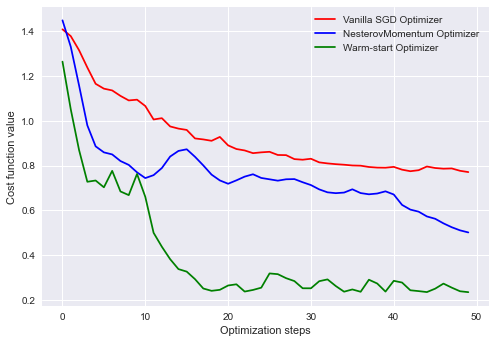

In [27]:
plt.style.use("seaborn")

plt.plot(cost_sgd, "r", label="Vanilla SGD Optimizer")
plt.plot(cost_nes, "b", label="NesterovMomentum Optimizer")
plt.plot(cost_wssgd, "g", label="Warm-start Optimizer")

plt.ylabel("Cost function value")
plt.xlabel("Optimization steps")
plt.legend()
plt.savefig('cost.pdf')
plt.show()

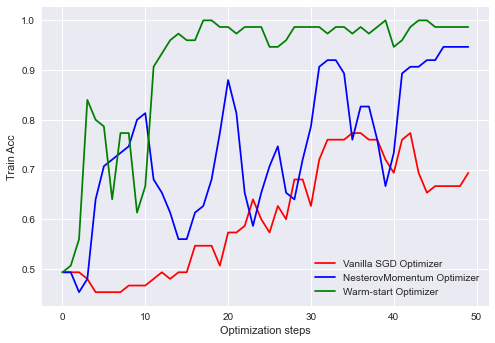

In [25]:
plt.style.use("seaborn")

plt.plot(train_acc_sgd, "r", label="Vanilla SGD Optimizer")
plt.plot(train_acc_nes, "b", label="NesterovMomentum Optimizer")
plt.plot(train_acc_wssgd, "g", label="Warm-start Optimizer")

plt.ylabel("Train Acc")
plt.xlabel("Optimization steps")
plt.legend()
plt.savefig('train_acc.pdf')
plt.show()

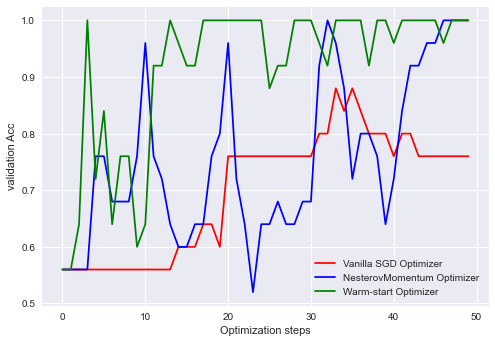

In [26]:
plt.style.use("seaborn")

plt.plot(val_acc_sgd, "r", label="Vanilla SGD Optimizer")
plt.plot(val_acc_nes, "b", label="NesterovMomentum Optimizer")
plt.plot(val_acc_wssgd, "g", label="Warm-start Optimizer")

plt.ylabel("validation Acc")
plt.xlabel("Optimization steps")
plt.legend()
plt.savefig('val_acc.pdf')
plt.show()